# Теледом. Прогноз оттока клиентов

**Описание проекта**

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

**Бизнес-задача:**

* избежать потери прибыли в результате оттока клиентов

**Цель проекта:**

* построить модель, предсказывающую расторжение договора клиентом.

**Ход исследования:**

1. Подготовка данных: загрузка и изучение общей информации из предоставленных датасетов
2. Анализ и предобработка данных: обработка пропущенных значений, дубликатов и других аномалий; объединение необходимых данных в один датасет; разработка новых признаков, необходимых для исследования; подготовка данных к обучению 
3. Разработка модели МО: поиск лучшей среди различных классов моделей, подбор гиперпараметров, сравнение оценочных метрик
4. Тестирование лучшей модели на отложенной выборке данных, анализ метрик модели, анализ важности входных признаков
5. Общий вывод и советы для бизнеса: резюмирование полученных результатов, формулировка ключевых выводов

**Описание данных**

Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:

`contract` — информация о договорах;

`personal` — персональные данные клиентов;

`internet` — информация об интернет-услугах;

`phone` — информация об услугах телефонии.

**Таблица contract**

`customerID` — ID абонента;

`BeginDate` — дата начала действия договора;

`EndDate` — дата окончания действия договора;

`Type` — тип оплаты: раз в год-два или ежемесячно;

`PaperlessBilling` — электронный расчётный лист;

`PaymentMethod` — тип платежа;

`MonthlyCharges` — расходы за месяц;

`TotalCharges` — общие расходы абонента.

**Таблица personal**

`customerID` — ID пользователя;

`gende`r — пол;

`SeniorCitizen` — является ли абонент пенсионером;

`Partner` — есть ли у абонента супруг или супруга;

`Dependents` — есть ли у абонента дети.

**Таблица internet**

`customerID` — ID пользователя;

`InternetService` — тип подключения;

`OnlineSecurity` — блокировка опасных сайтов;

`OnlineBackup` — облачное хранилище файлов для резервного копирования данных;

`DeviceProtection` — антивирус;

`TechSupport` — выделенная линия технической поддержки;

`StreamingTV` — стриминговое телевидение;

`StreamingMovies` — каталог фильмов.

**Таблица phone**

`customerID` — ID пользователя;

`MultipleLines` — подключение телефона к нескольким линиям одновременно.

*Информация о договорах актуальна на 1 февраля 2020.*

In [1]:
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db -q

In [2]:
!pip install phik -q
!pip install optuna -q
!pip install optuna-integration -q
!pip install catboost -q
!pip install scikit-learn==1.2 -q
!pip install seaborn==0.13.0 -q
!pip install matplotlib==3.4.1 -q
!pip install optuna -q
!pip install ipywidgets -q
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy.stats as st
import phik
from sqlalchemy import create_engine

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.optimizers import Adam

import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner

from catboost import CatBoostClassifier, cv, Pool
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_auc_score, 
                             PrecisionRecallDisplay, classification_report)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [4]:
TEST_SIZE = 0.25
RANDOM_STATE = 120126
sns.set(rc={'figure.figsize' : (12, 8)})
sns.set(style='darkgrid')
optuna.logging.set_verbosity(optuna.logging.WARNING)

## Загрузка данных

In [5]:
# Подключимся к базе данных
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

In [6]:
# Посмотрим какие таблицы есть в БД
"SELECT name FROM sqlite_master"
query = '''
SELECT *
FROM sqlite_master;
'''
pd.read_sql_query(query, con=engine)['name']

0           data_arc
1          data_bulk
2     data_bulk_time
3     data_wire_time
4           contract
5           personal
6              phone
7           internet
8           data_gas
9          data_temp
10         data_wire
Name: name, dtype: object

В БД имеются необходимые нам таблицы `contract`, `personal`, `phone` и `internet`

## Анализ и предобработка данных

### Анализ табличных данных

**Таблица contract**

In [7]:
# Посмотрим на данные
query = '''
SELECT *
FROM contract;
'''
contract = pd.read_sql_query(query, con=engine)
contract.head()

customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges TotalCharges  
0           Electronic check          29.85        31.04  
1               Mailed check          56.95      2071.84  
2               Mailed check          53.85       226.17  
3  Bank transfer (automatic)           42.3       1960.6  
4           Electronic check           70.7        353.5

In [8]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


In [9]:
# Проверим данные на полные дубликаты
contract.duplicated().sum()

0

Проверим данные на неявные дубликаты

In [10]:
# Убедимся что все абоненты имеют уникальных номер
contract['customerID'].nunique()

7043

In [11]:
for i in ['Type', 'PaperlessBilling', 'PaymentMethod']:
    print(f'Колонка {i} содержит уникальные значения: {contract[i].unique()}')

Колонка Type содержит уникальные значения: ['Month-to-month' 'One year' 'Two year']
Колонка PaperlessBilling содержит уникальные значения: ['Yes' 'No']
Колонка PaymentMethod содержит уникальные значения: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [12]:
# Изменим тип данных
contract['MonthlyCharges'] = contract['MonthlyCharges'].astype('float')

In [13]:
# Посмотрим на данные с пропусками
contract.query("TotalCharges == ' '")

customerID   BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI  2020-02-01      No  Two year              Yes   
753   3115-CZMZD  2020-02-01      No  Two year               No   
936   5709-LVOEQ  2020-02-01      No  Two year               No   
1082  4367-NUYAO  2020-02-01      No  Two year               No   
1340  1371-DWPAZ  2020-02-01      No  Two year               No   
3331  7644-OMVMY  2020-02-01      No  Two year               No   
3826  3213-VVOLG  2020-02-01      No  Two year               No   
4380  2520-SGTTA  2020-02-01      No  Two year               No   
5218  2923-ARZLG  2020-02-01      No  One year              Yes   
6670  4075-WKNIU  2020-02-01      No  Two year               No   
6754  2775-SEFEE  2020-02-01      No  Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  
488   Bank transfer (automatic)           52.55               
753                Mailed check           20.25               
936                Mailed check           80.85               
1082               Mailed check           25.75               
1340    Credit card (automatic)           56.05               
3331               Mailed check           19.85               
3826               Mailed check           25.35               
4380               Mailed check           20.00               
5218               Mailed check           19.70               
6670               Mailed check           73.35               
6754  Bank transfer (automatic)           61.90

Всех клиентов в данной выборке объединяет то, что они заключили договор 01.02.2020. А согласно описанию полученных данных - `Информация о договорах актуальна на 1 февраля 2020`, поэтому данные в этой колонке появятся только со 2-го месяца. 

In [14]:
# Заменим пропущенные значения на 0
contract["TotalCharges"] = np.where(contract["TotalCharges"] == ' ', 0, contract["TotalCharges"])

In [15]:
# Проверим
contract.query("BeginDate == '2020-02-01'")

customerID   BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI  2020-02-01      No  Two year              Yes   
753   3115-CZMZD  2020-02-01      No  Two year               No   
936   5709-LVOEQ  2020-02-01      No  Two year               No   
1082  4367-NUYAO  2020-02-01      No  Two year               No   
1340  1371-DWPAZ  2020-02-01      No  Two year               No   
3331  7644-OMVMY  2020-02-01      No  Two year               No   
3826  3213-VVOLG  2020-02-01      No  Two year               No   
4380  2520-SGTTA  2020-02-01      No  Two year               No   
5218  2923-ARZLG  2020-02-01      No  One year              Yes   
6670  4075-WKNIU  2020-02-01      No  Two year               No   
6754  2775-SEFEE  2020-02-01      No  Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  
488   Bank transfer (automatic)           52.55            0  
753                Mailed check           20.25            0  
936                Mailed check           80.85            0  
1082               Mailed check           25.75            0  
1340    Credit card (automatic)           56.05            0  
3331               Mailed check           19.85            0  
3826               Mailed check           25.35            0  
4380               Mailed check           20.00            0  
5218               Mailed check           19.70            0  
6670               Mailed check           73.35            0  
6754  Bank transfer (automatic)           61.90            0

In [16]:
# Изменим тип данных
contract['TotalCharges'] = contract['TotalCharges'].astype('float')

In [17]:
contract.describe().T

count         mean          std    min     25%      50%  \
MonthlyCharges  7043.0    64.761692    30.090047  18.25   35.50    70.35   
TotalCharges    7043.0  2115.312885  2112.742814   0.00  436.75  1343.35   

                    75%      max  
MonthlyCharges    89.85   118.75  
TotalCharges    3236.69  9221.38

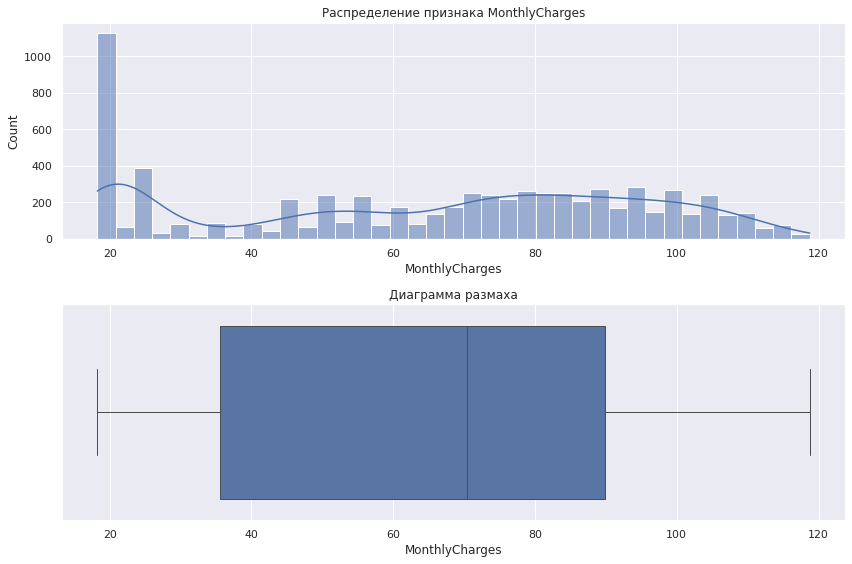

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1)
sns.histplot(data=contract['MonthlyCharges'], bins='rice', kde=True, ax=ax[0])
ax[0].set_title(f'Распределение признака MonthlyCharges')

sns.boxplot(x=contract['MonthlyCharges'], ax=ax[1])
ax[1].set_title('Диаграмма размаха')
plt.tight_layout()

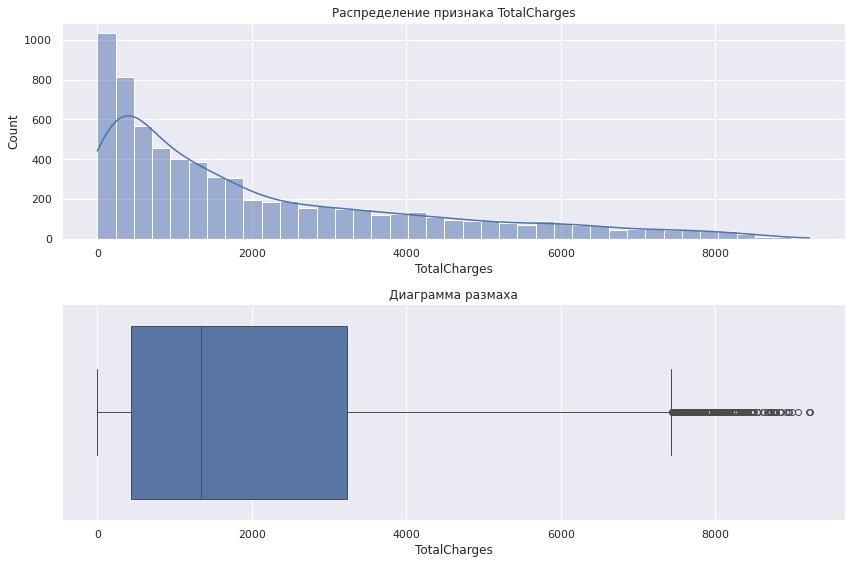

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=1)
sns.histplot(data=contract['TotalCharges'], bins='rice', kde=True, ax=ax[0])
ax[0].set_title(f'Распределение признака TotalCharges')

sns.boxplot(x=contract['TotalCharges'], ax=ax[1])
ax[1].set_title('Диаграмма размаха')
plt.tight_layout()

Смотря на график, напрашивается предположение, что оператор связи не способен удержать клиентов. Диаграмма размаха не выявила аномальных значений.

**Таблица personal**

In [20]:
# Посмотрим на данные
query = '''
SELECT *
FROM personal;
'''
personal = pd.read_sql_query(query, con=engine)
personal.head()

customerID  gender SeniorCitizen Partner Dependents
0  7590-VHVEG  Female             0     Yes         No
1  5575-GNVDE    Male             0      No         No
2  3668-QPYBK    Male             0      No         No
3  7795-CFOCW    Male             0      No         No
4  9237-HQITU  Female             0      No         No

In [21]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


In [22]:
# Проверим данные на полные дубликаты
personal.duplicated().sum()

0

Проверим данные на неявные дубликаты

In [23]:
personal.customerID.nunique()

7043

In [24]:
# Изменим тип данных
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('float')

In [25]:
for i in personal.columns.drop("customerID"):
    print(f'Колонка {i} содержит уникальные значения: {personal[i].unique()}')

Колонка gender содержит уникальные значения: ['Female' 'Male']
Колонка SeniorCitizen содержит уникальные значения: [0. 1.]
Колонка Partner содержит уникальные значения: ['Yes' 'No']
Колонка Dependents содержит уникальные значения: ['No' 'Yes']


**Таблица internet**

In [26]:
# Посмотрим на данные
query = '''
SELECT *
FROM internet;
'''
internet = pd.read_sql_query(query, con=engine)
internet.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [27]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [28]:
# Проверим данные на полные дубликаты
internet.duplicated().sum()

0

Проверим данные на неявные дубликаты

In [29]:
internet.customerID.nunique()

5517

In [30]:
for i in internet.columns.drop("customerID"):
    print(f'Колонка {i} содержит уникальные значения: {internet[i].unique()}')

Колонка InternetService содержит уникальные значения: ['DSL' 'Fiber optic']
Колонка OnlineSecurity содержит уникальные значения: ['No' 'Yes']
Колонка OnlineBackup содержит уникальные значения: ['Yes' 'No']
Колонка DeviceProtection содержит уникальные значения: ['No' 'Yes']
Колонка TechSupport содержит уникальные значения: ['No' 'Yes']
Колонка StreamingTV содержит уникальные значения: ['No' 'Yes']
Колонка StreamingMovies содержит уникальные значения: ['No' 'Yes']


**Таблица phone**

In [31]:
# Посмотрим на данные
query = '''
SELECT *
FROM phone;
'''
phone = pd.read_sql_query(query, con=engine)
phone.head()

CustomerId MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

In [32]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerId     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [33]:
# Проверим данные на полные дубликаты
phone.duplicated().sum()

0

In [34]:
# Переименнуем CustomerId
phone.rename(columns={'CustomerId':'customerID'}, inplace=True)

Проверим данные на неявные дубликаты

In [35]:
print(phone.customerID.nunique(), phone.MultipleLines.unique())

6361 ['No' 'Yes']


### Объединение  датафреймов и создание новых признаков

In [36]:
# Объединим датафреймы по колонке customerID
data = contract.merge(personal, on='customerID')
data = data.merge(internet, how='left', on='customerID')
data = data.merge(phone, how='left', on='customerID')

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   float64
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [38]:
# Переведем целевой признак в отдельную переменную 
data['target'] = data['EndDate'].apply(lambda x: 0 if x=='No' else 1)

In [39]:
# Создадим новый признак - длительность контракта абонента (в днях)
# для этого необходимо из даты окончания договора вычесть
# дату начала действия договора и перевести в дни
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')
data["EndDate"] = data["EndDate"].apply(lambda x: '2020-02-01' if x=='No' else x)
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d')

data['ContractLength'] = (data['EndDate'] - data['BeginDate']).dt.days

In [40]:
# Выделим бинарные признаки
binary_features = data.select_dtypes(include='object').columns.drop(['customerID', 'Type', 'PaymentMethod', 
                                                   'gender', 'InternetService', 'MultipleLines'])

In [41]:
# Приведем бинарные признаки к виду {No:0, Yes:1}
for i in binary_features:
    data[i] = data[i].map({'No': 0, 'Yes': 1, np.nan: np.nan})

In [42]:
# Создадим новый признак - общее количество подключённых услуг
data['num_of_services'] = data[[
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies']].sum(axis=1)

In [43]:
# Создадим новый признак - расходы на услуги связи и интернета за день
data['expenses_for_day'] = round((data['TotalCharges'] / data['ContractLength']), 2)

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   float64       
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   float64       
 10  Partner           7043 non-null   float64       
 11  Dependents        7043 non-null   float64       
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   float64       
 14  OnlineBackup      5517 n

Можно предположить, что среди 7043 клиентов компании: 6361 абонент пользуется услугой `MultipleLines`, а остальные нет, поэтому кажется логичным заменить пропуски в этой колонке на заглушку `no_PhoneLine`. И стоит рассуждать в том же ключе об интернет-услугах: 5517 абонентов из 7043 используют те или иные интернет-услуги, а у остальных не подлкючен интернет (*InternetService*) и они соответсвтенно не являются пользователями интернет-услуг, поэтому пропуски в этих признаках можно заменить на `0`. В колонке `InternetService` пропуски заменить заглушкой `no_internet`. Пропуски в признаке `expenses_for_day` заменим значением `0`  

In [45]:
# Заменим пропуски заглушкой
data['InternetService'].fillna('no_internet', inplace=True)
data['MultipleLines'].fillna('no_PhoneLine', inplace=True)

In [46]:
data['expenses_for_day'].fillna(0, inplace=True)

In [47]:
# Заменим пропуски на значение 0
data.fillna(0, inplace=True)

In [48]:
# Проверим
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   float64       
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   float64       
 10  Partner           7043 non-null   float64       
 11  Dependents        7043 non-null   float64       
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   float64       
 14  OnlineBackup      7043 n

In [49]:
# Проверим данные на полные дубликаты
data.duplicated().sum()

0

### Графический анализ

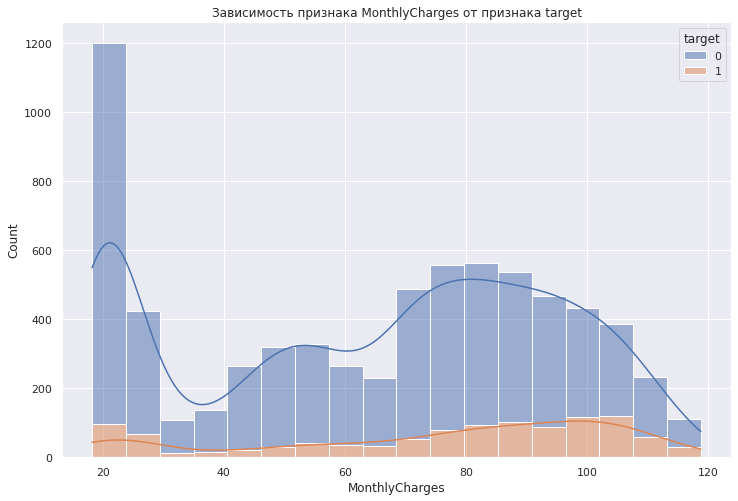

In [50]:
sns.histplot(data=data, x='MonthlyCharges', hue='target', multiple='stack', stat='count', kde=True)
plt.title(f'Зависимость признака MonthlyCharges от признака target');

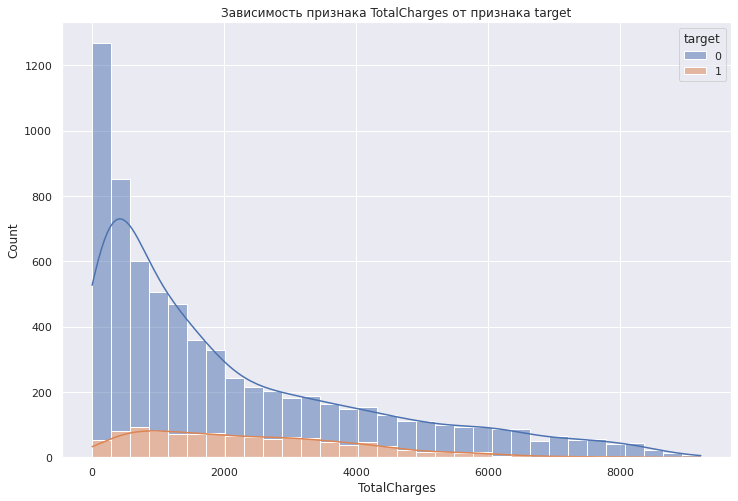

In [51]:
sns.histplot(data=data, x='TotalCharges', hue='target', multiple='stack', stat='count', kde=True)
plt.title(f'Зависимость признака TotalCharges от признака target');

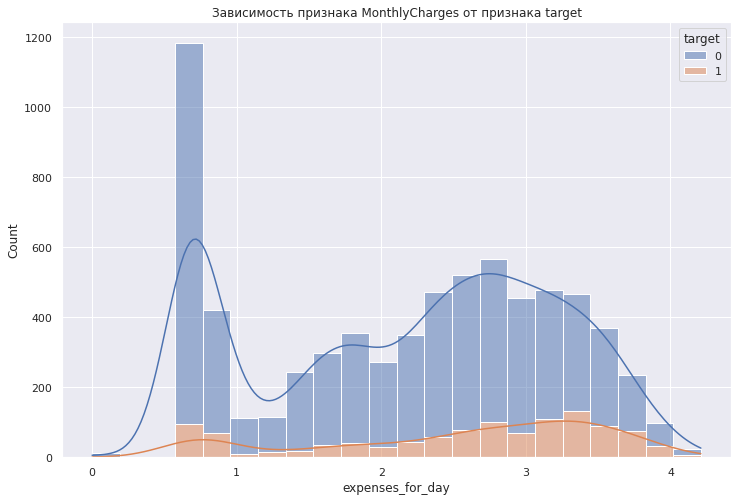

In [52]:
sns.histplot(data=data, x='expenses_for_day', hue='target', multiple='stack', stat='count', kde=True)
plt.title(f'Зависимость признака MonthlyCharges от признака target');

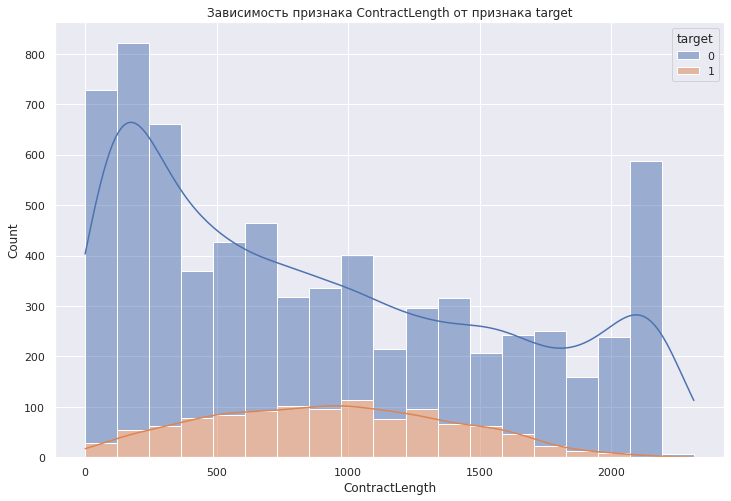

In [53]:
sns.histplot(data=data, x='ContractLength', hue='target', multiple='stack', stat='count', kde=True)
plt.title(f'Зависимость признака ContractLength от признака target');

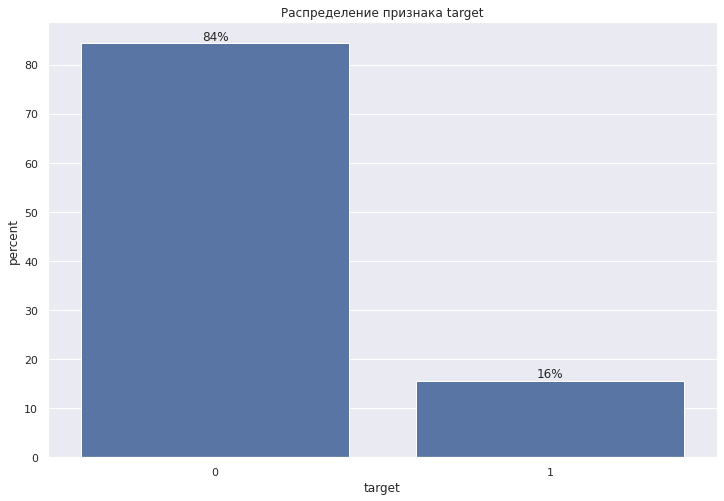

In [54]:
ax = sns.countplot(data=data, x='target', stat='percent')

for cont in ax.containers:
    ax.bar_label(cont, fmt='%.0f%%')
plt.title(f'Распределение признака target')
plt.show()

In [55]:
# Рассчитаем соотношение классов целевого признака
len(data.query('target == 0')) / len(data.query('target == 1'))

5.396911898274296

Соотношение классов целевого признака составляет 5 к 1. При обучении моделей эти данные можно использовать как гиперпараметр

In [56]:
def plot_countplots(df, features_col, target_col, cols_per_row=3):
    """
    Countplot для категориальных признаков с разделением по таргету
    """
    n_cols = len(features_col)
    n_rows = (n_cols + cols_per_row - 1) // cols_per_row
    
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(cols_per_row*5, n_rows*5))
    axes = axes.flatten()
    
    for idx, col in enumerate(features_col):
        ax = axes[idx]
        
        # Строим countplot
        sns.countplot(data=df, x=col, hue=target_col, ax=ax, palette='viridis')
        
        # Добавляем проценты на столбцы
        total = len(df)
        for container in ax.containers:
            for bar in container:
                height = bar.get_height()
                if height > 0:
                    percentage = height / total * 100
                    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
                           f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)
        
        ax.set_title(f'{col}', fontweight='bold', fontsize=12)
        ax.set_xlabel('')
        ax.legend(title=target_col)
        ax.grid(True)
        ax.tick_params(axis='x', rotation=45)
    
    # Скрываем пустые subplots
    for idx in range(len(features_col), len(axes)):
        axes[idx].set_visible(False)
        
    plt.suptitle(f'Распределение бинарных признаков по {target_col}\n\n', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

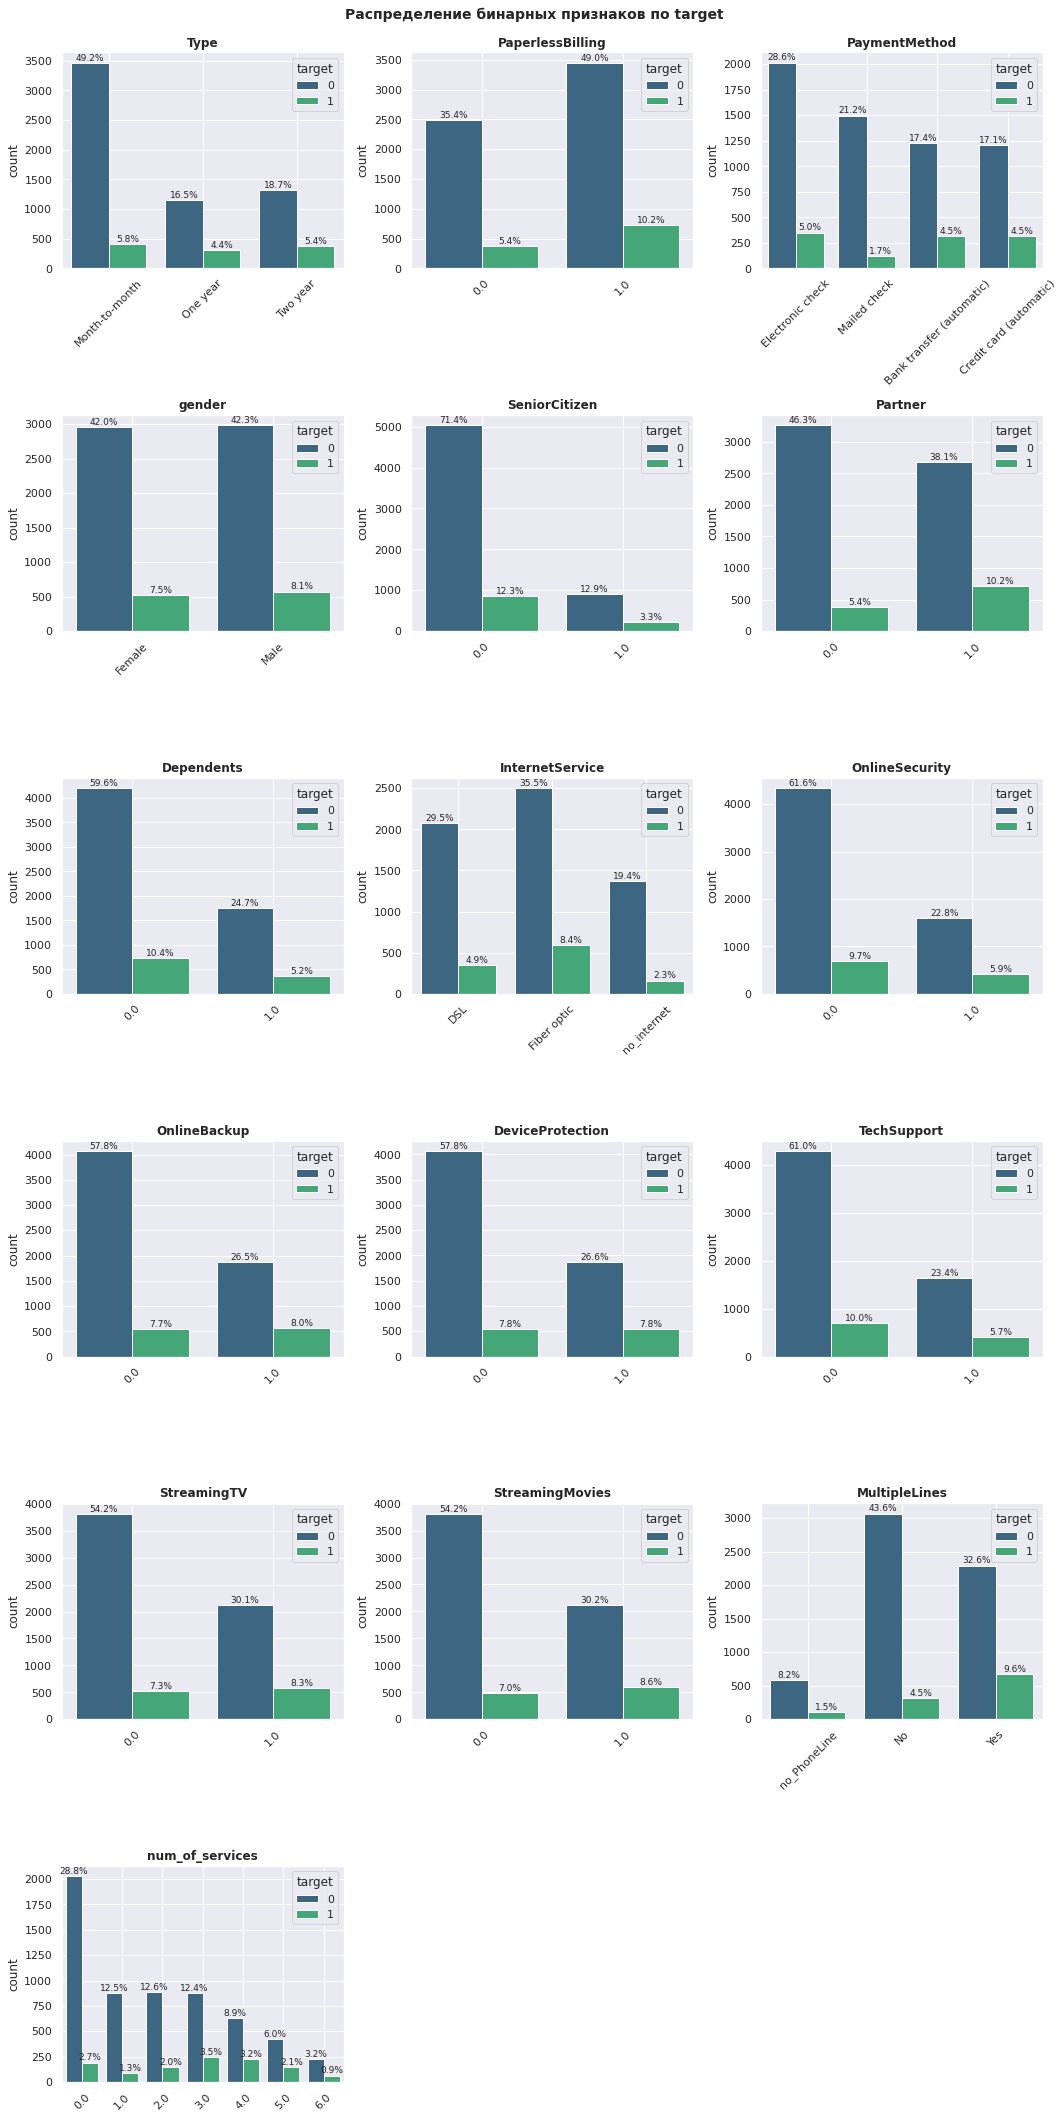

In [57]:
# Использование
cat_features = data.columns.drop(['customerID', 'BeginDate', 'EndDate', 
                                  'MonthlyCharges', 'TotalCharges',
                                  'target', 'ContractLength', 'expenses_for_day'])

plot_countplots(data, cat_features, 'target')

Из анализа графиков можно сделать следующие выводы:
* **Расторгают контракт абоненты с ежемесячным платежом выше среднего значения.**
* **Уходят клиенты с ежедневным платежом выше среднего значения.**
* **Чаще других уходят клиенты, получающие электронный чек. С ним проще вести учет расходов.**
* **Клиенты, оплачивающие кредитной картой услуги оператора ТелеДом, чаще других склонны к расторжению контракта**
* **Пенсионеры склонны прекращать пользоваться услугами оператора связи. Возможно нет потребоности, а возможно просто дорого.**
* **Клиенты состоящие в браке склонны к расторжению договора. Возможно, причиной этого является оптимизация расходов.**
* **Абоненты с детьми склонны к расторжению договора. Можно предположить причину - оптимизация расходов.**
* **Наличие большого числа подключенных услуг (3 и более), может подтолкнуть клиента к прекращению договорных отношений.**


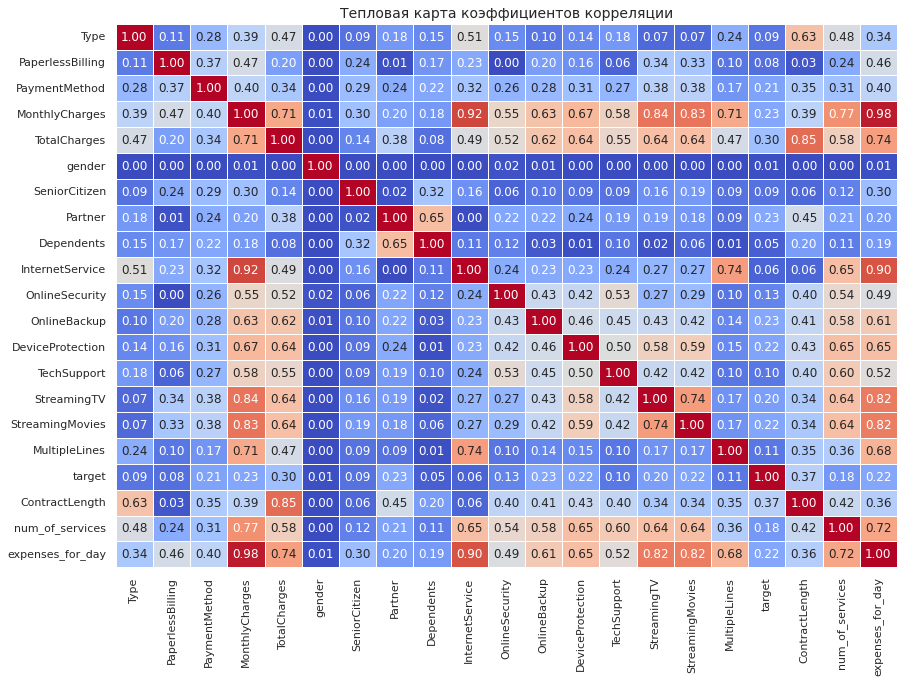

In [58]:
# Вычисление матрицы корреляции с использованием phik 
# избавимся от ненужных признаков
matrix_corr = data.drop(['customerID', 'BeginDate', 'EndDate'], axis=1) # избавимся от ненужных признаков

# зададим переменную с непрерывными признаками 
interval_cols = ['MonthlyCharges', 'TotalCharges', 'ContractLength', 'expenses_for_day', 'num_of_services'] 

# Построим тепловую карту коэффициентов корреляции рассчитаных с использованием phik 
plt.figure(figsize=(14, 10))
sns.heatmap(matrix_corr.phik_matrix(interval_cols = interval_cols), 
            annot=True, fmt=".2f", cmap='coolwarm', cbar=False, linewidths=0.5)
plt.title('Тепловая карта коэффициентов корреляции', fontsize=14)
plt.show()

Мультиколлениарность наблюдается между признаками `expenses_for_day и InternetService, MonthlyCharges`, `InternetService, StreamingTV, StreamingMovies` и признаком `MonthlyCharges`.
Так же сильная корреляция между признаками `num_of_services` и `OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines`

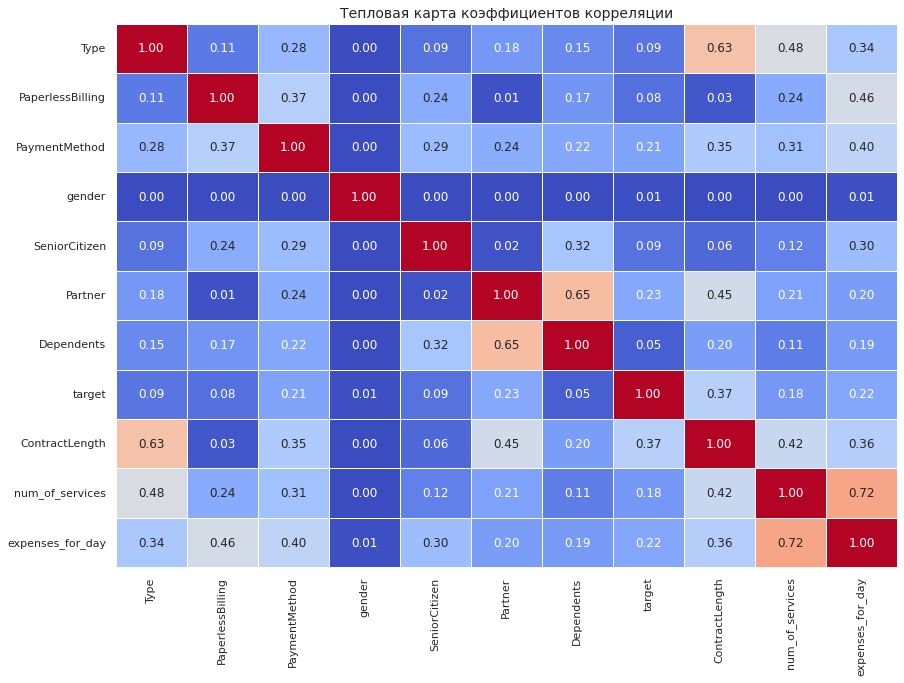

In [59]:
# Вычисление матрицы корреляции с использованием phik 
# избавимся неважных признаков и признаков с мультиколлениарностью
matrix_corr_1 = data.drop(['customerID', 'BeginDate', 'EndDate', 'InternetService', 'TotalCharges', 
                           'MonthlyCharges', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                           'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'], axis=1) 

# зададим переменную с непрерывными признаками 
interval_cols = ['ContractLength', 'expenses_for_day', 'num_of_services'] 

# Построим тепловую карту коэффициентов корреляции рассчитаных с использованием phik 
plt.figure(figsize=(14, 10))
sns.heatmap(matrix_corr_1.phik_matrix(interval_cols = interval_cols), 
            annot=True, fmt=".2f", cmap='coolwarm', cbar=False, linewidths=0.5)
plt.title('Тепловая карта коэффициентов корреляции', fontsize=14)
plt.show()

In [60]:
# На основе сделанных выводов удалим ненужные признаки
drop_features = ['customerID', 'BeginDate', 'EndDate', 'TotalCharges', 'MonthlyCharges', 'InternetService', 
                 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                 'StreamingMovies', 'MultipleLines']

### Подготовка данных к обучению

In [61]:
# Удалим неинформативные для модели признаки
df = data.drop(drop_features, axis=1)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   float64
 2   PaymentMethod     7043 non-null   object 
 3   gender            7043 non-null   object 
 4   SeniorCitizen     7043 non-null   float64
 5   Partner           7043 non-null   float64
 6   Dependents        7043 non-null   float64
 7   target            7043 non-null   int64  
 8   ContractLength    7043 non-null   int64  
 9   num_of_services   7043 non-null   float64
 10  expenses_for_day  7043 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 918.3+ KB


In [63]:
# Разбиваем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1),
                                                    df['target'],
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE, 
                                                    stratify = df['target']
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5282, 10), (1761, 10), (5282,), (1761,))

In [64]:
# Выделим количественные признаки
num_columns = ['ContractLength', 'expenses_for_day', 'num_of_services']

In [65]:
# Выделим категориальные признаки
ohe_columns = df.select_dtypes(exclude='number').columns.tolist()
ohe_columns

['Type', 'PaymentMethod', 'gender']

In [66]:
# Пайплайн для подготовки категориальных признаков
ohe_pipe = Pipeline(
    [('simpleImputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
)

In [67]:
# Общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns) 
    ],
    remainder='passthrough'
)

In [68]:
X_train_pre = data_preprocessor.fit_transform(X_train)
X_test_pre = data_preprocessor.transform(X_test)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Обучение моделей

### LogisticRegression

В качестве базовой модели выберем **LogisticRegression** 

In [69]:
pipe_lr= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

pipe_lr.fit(X_train, y_train) 
print(f'Метрика roc_auc: {roc_auc_score(y_train, pipe_lr.predict_proba(X_train)[:, 1])}')

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Метрика roc_auc: 0.7409101801418008


In [70]:
results = pd.DataFrame(columns=['model', 'roc_auc'])
results.loc[len(results)] = ['LinearRegression', 
                             roc_auc_score(y_train, pipe_lr.predict_proba(X_train)[:, 1])]
results

model  roc_auc
0  LinearRegression  0.74091

### RandomForestClassifier

Для подбора гиперпараметров модели **RandomForestClassifier** используем библиотеку **Optuna** и инструмент **OptunaSearchCV** интегрированный с фреймворком Scikit-learn

In [71]:
clf_rf = RandomForestClassifier(class_weight="balanced", random_state=RANDOM_STATE)

params = {
    "max_features": optuna.distributions.CategoricalDistribution(["sqrt", "log2", None]),
    "n_estimators" : optuna.distributions.IntDistribution(20, 300, step=20),
    "max_depth" : optuna.distributions.IntDistribution(1, 20, step=1),
    "min_samples_split" : optuna.distributions.IntDistribution(2, 20),
    "min_samples_leaf" : optuna.distributions.IntDistribution(1, 20)
} 

optuna_search = optuna.integration.OptunaSearchCV(clf_rf,
                                                  params,
                                                  scoring='roc_auc',
                                                  cv=StratifiedKFold(),
                                                  n_trials=100,
                                                  n_jobs=-1,
                                                  random_state=RANDOM_STATE)

/tmp/ipykernel_78/3936664124.py:11: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(clf_rf,


In [72]:
%%time
optuna_search.fit(X_train_pre, y_train)

CPU times: user 10min 37s, sys: 2min 41s, total: 13min 19s
Wall time: 13min 20s


OptunaSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
               estimator=RandomForestClassifier(class_weight='balanced',
                                                random_state=120126),
               n_jobs=-1, n_trials=100,
               param_distributions={'max_depth': IntDistribution(high=20, log=False, low=1, step=1),
                                    'max_features': CategoricalDistribution(choices=('sqrt', 'log2', None)),
                                    'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1),
                                    'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1),
                                    'n_estimators': IntDistribution(high=300, log=False, low=20, step=20)},
               random_state=120126, scoring='roc_auc')

In [73]:
optuna_search.best_params_

{'max_features': 'sqrt',
 'n_estimators': 100,
 'max_depth': 14,
 'min_samples_split': 3,
 'min_samples_leaf': 14}

In [74]:
optuna_search.best_score_

0.8214205468369234

In [75]:
results.loc[len(results)] = ['RandomForestClassifier', 
                             optuna_search.best_score_]
results

model   roc_auc
0        LinearRegression  0.740910
1  RandomForestClassifier  0.821421

### CatBoostClassifier

Подбор гиперпараметров для модели **CatBoostClassifier** осуществим также при помощи библиотеки **Optuna** и инструментов встроенной кросс-валидации CatBoost

Наша цель это оптимизировать классификатор так, чтобы максимизировать метрику на валидационном наборе данных 

In [76]:
pool = Pool(X_train, y_train, cat_features=ohe_columns)

In [77]:
# Зададим фиксированные параметры для модели
FIXED_PARAMS = {
    "early_stopping_rounds": 20, 
    "scale_pos_weight": 5.0, 
    "objective": 'Logloss', 
    "eval_metric": 'AUC', 
    "logging_level": "Silent", 
    "random_seed": RANDOM_STATE
}

In [78]:
def objective(trial):   
    opt_params = {
        "iterations" : trial.suggest_int("iterations", 100, 1500),
        "depth": trial.suggest_int("depth", 1, 16, step=1),
        "learning_rate" : trial.suggest_float("learning_rate", 1e-3, 0.3, log=True)
    }
    
    param = {**FIXED_PARAMS, **opt_params}
   
    cv_data = cv(
            pool=pool,
            params=param,
            fold_count=5,  
            shuffle=True,
            partition_random_seed=RANDOM_STATE,
            plot=False,
            verbose=False,
            stratified=True 
)
    return cv_data['test-AUC-mean'].max()

In [79]:
study = optuna.create_study(direction="maximize",sampler=TPESampler(), pruner=HyperbandPruner())

In [80]:
%%time
study.optimize(objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

CPU times: user 17min 21s, sys: 5min 14s, total: 22min 36s
Wall time: 22min 43s


In [81]:
# Показывает при каких гиперпараметрах достигнут лучший результат
study.best_params

{'iterations': 314, 'depth': 2, 'learning_rate': 0.2852342378003294}

In [82]:
study.best_value

0.9219195948719479

In [83]:
plot_optimization_history(study)

In [84]:
plot_param_importances(study)

График помогает понять, какие гиперпараметры больше всего влияют на результаты экспериментов.

In [85]:
results.loc[len(results)] = ['CatBoostClassifier', 
                             study.best_value]
results

model   roc_auc
0        LinearRegression  0.740910
1  RandomForestClassifier  0.821421
2      CatBoostClassifier  0.921920

### NeuralNetwork

Подбор гиперпараметров для полносвязной нейронной сети с 2-мя скрыми слоями при помощи библиотеки **Optuna**

In [86]:
def objective_nn(trial):
    dropout = trial.suggest_float("dropout", 0.2, 0.8)
    batch_size = trial.suggest_int("batch_size", 32, 128, step=32)
    epochs = trial.suggest_int("epochs", 50, 150, step=25)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.3, log=True)
    activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'swish'])
    
    model = keras.Sequential([
        layers.Dense(64, activation=activation, input_shape=(X_train_pre.shape[1],)),
        layers.Dropout(dropout),
        layers.Dense(32, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='auc')]
    )
    callbacks = [keras.callbacks.EarlyStopping(
        monitor="loss", 
        patience=10, 
        mode='min', 
        restore_best_weights=True, 
        verbose=0)]
    
    history = model.fit(
        X_train_pre, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=0
    )
    
    return max(history.history['val_auc'])

In [87]:
study_nn = optuna.create_study(direction="maximize", sampler=TPESampler(), pruner=HyperbandPruner())

In [88]:
%%time
study_nn.optimize(objective_nn, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

2026-02-08 11:52:44.301845: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 21min 18s, sys: 4min 56s, total: 26min 14s
Wall time: 26min 18s


In [89]:
study_nn.best_params

{'dropout': 0.20293407433094326,
 'batch_size': 32,
 'epochs': 125,
 'learning_rate': 0.029105679853536955,
 'activation': 'leaky_relu'}

In [90]:
study_nn.best_value

0.806412935256958

In [91]:
plot_optimization_history(study_nn)

In [92]:
plot_param_importances(study_nn)

In [93]:
results.loc[len(results)] = ['NeuralNetwork', study_nn.best_value]
results

model   roc_auc
0        LinearRegression  0.740910
1  RandomForestClassifier  0.821421
2      CatBoostClassifier  0.921920
3           NeuralNetwork  0.806413

**Вывод по обучению моделей:**

Также тестировались и глубокие нейронные сети c бОльшим количеством нейронов, скрытых слоев и добавлением "батч-норма", но прироста в метрике они не добавили, зато времени на подбор гиперпараметров уходило значительно больше. Единственное, что привело к повышению метрики - это обучение модели на всём объеме признаков (полный объем признаков до удаления некоторых по результатам анализа данных), но и в этом случае рост метрики был не слишком существенным ≈ 1,5%. И все также не было разницы в метрике качества между моделью с достаточно простой архитектурой и глубокой моделью.

Стоит так же отметить, что на полном объеме признаков у других классов моделей не наблюдалось повышение метрики качества.

In [94]:
# Выберем лучшую модель
results.sort_values('roc_auc', ascending=False)

model   roc_auc
2      CatBoostClassifier  0.921920
1  RandomForestClassifier  0.821421
3           NeuralNetwork  0.806413
0        LinearRegression  0.740910

Лучшая модель по результатам тестов - *CatBoostClassifier*

In [95]:
# Гиперпараметры лучшей модели
best_params = {**FIXED_PARAMS, **study.best_params}
best_params

{'early_stopping_rounds': 20,
 'scale_pos_weight': 5.0,
 'objective': 'Logloss',
 'eval_metric': 'AUC',
 'logging_level': 'Silent',
 'random_seed': 120126,
 'iterations': 314,
 'depth': 2,
 'learning_rate': 0.2852342378003294}

## Тестирование и анализ лучшей модели.

### Тестирование модели

In [96]:
# Обучим лучшую модель
catboost = CatBoostClassifier(**best_params).fit(pool, verbose=False)

In [97]:
# Рассчитаем метрики для оценки модели на тестовых данных
y_pred = catboost.predict(X_test)
print(f'Метрика roc_auc на тестовых данных: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}')
print(f'Метрика accuracy на тестовых данных: {accuracy_score(y_test, y_pred)}')

Метрика roc_auc на тестовых данных: 0.9149798115746971
Метрика accuracy на тестовых данных: 0.8750709823963657


Метрика `roc_auc` позволяет оценить качество работы модели вне зависимости от выбранного порога вероятности, поэтому значение равное `0.92` следует считать очень хорошим результатом.

Метрика `accuracy=0.90` означает, что модель верно предсказывает класс в 90% случаев. Это хороший результат, но все же стоит рассмотреть подробней точность предсказаний каждого класса.

### Анализ матрицы ошибок

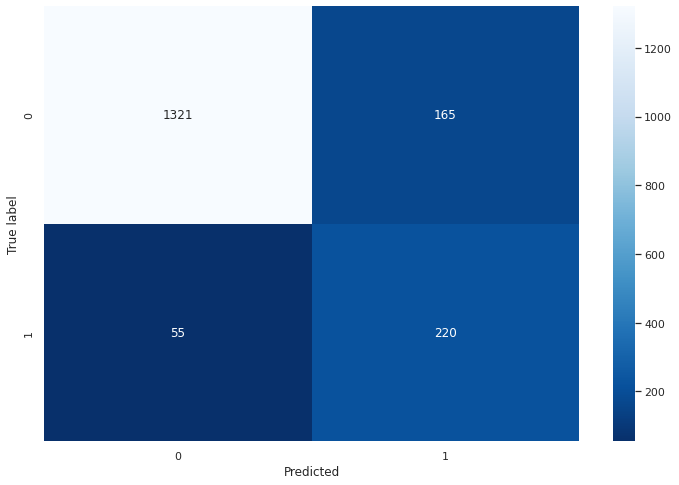

In [98]:
# Построим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

In [99]:
# Оценим точность лучшей модели
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

precision    recall  f1-score      support
0              0.960029  0.888964  0.923131  1486.000000
1              0.571429  0.800000  0.666667   275.000000
accuracy       0.875071  0.875071  0.875071     0.875071
macro avg      0.765729  0.844482  0.794899  1761.000000
weighted avg   0.899345  0.875071  0.883081  1761.000000

**Проведя анализ матрицы ошибок, можно сделать несколько выводов:**
* Модель очень хорошо предсказывает оставшихся клиентов - 1389 из 1486 были верно отнесены к своему классу. Это говорит о высокой точности модели в определении таких абонентов. 

* А вот ушедших клиентов модель предсказывает не очень хорошо - только 203 из 275 было верно отнесены к своему классу. Также 71 были неверно классифицированы моделью, как оставшиеся клиенты. 

Почему так произошло? Вероятней всего, причина в малом количестве данных по таким клиентам. Отчасти это можно исправить, настроив точность предсказания одного из классов. Делается это с помощью сдвига порога классификации. Например, сдвинув порог в сторону уменьшения кол-во ложноотрицательных ошибок (сейчас их 72), мы увеличим не только кол-во верных предсказаний класса 1, но и кол-во ложноположительных ошибок (сейчас их 97). Переведем это на язык конкретных дейсвтий: в данном случае, мы будем пытаться с помощью, например, предоставления дополнительный скидки на услуги, удержать еще большее кол-во клиентов, которые в том числе и так не собирались уходить.  Поэтому при принятии таких решений на первый план выходит экономическая целесообразность и бизнес-метрики, такие как стоимость удержания клинета, средняя прибыль с клиента.  

**График Precision-Recall**

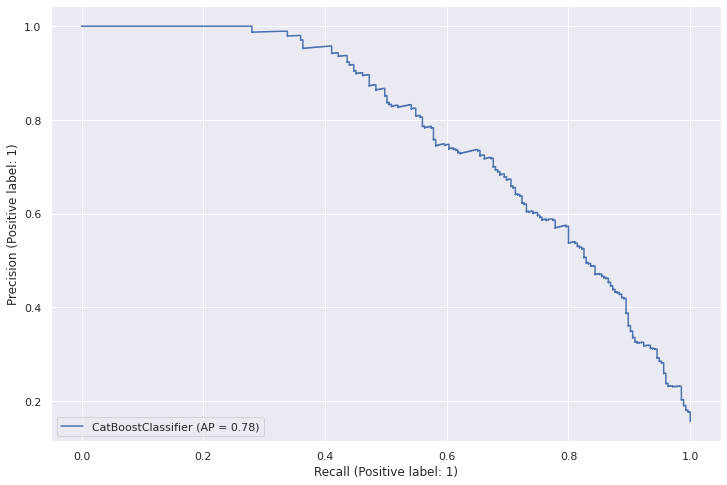

In [100]:
PrecisionRecallDisplay.from_estimator(catboost, X_test, y_test);

График показывает, как меняется баланс между точностью (precision) и полнотой (recall)при разных настройках чувствительности модели. В нашем случае мы перестанем упускать ушедших клиентов, при значении precision < 0.2. 

### Анализ важности признаков

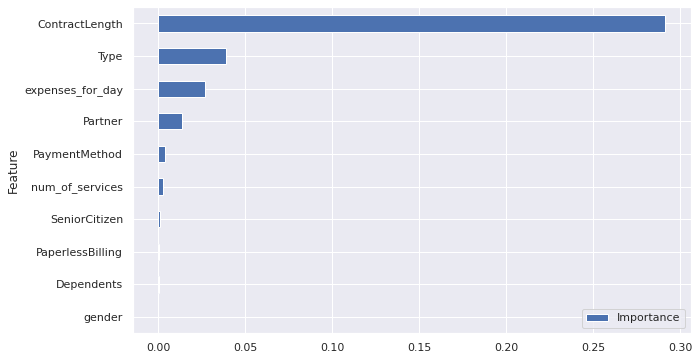

In [101]:
# Для оценки важности признаков модели воспользуемся инструментом permutation_importance
result = permutation_importance(catboost, X_test, y_test, scoring='roc_auc')

feature_importance = pd.DataFrame({'Feature': X_train.columns.tolist(), 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

Наиболее важными признками для модели являются: **длительность контракта с клиентом (в днях), тип оплаты, количество подключенных услуг, расходы на услуги связи и интернета в день и наличие у абонента супруга/супрги**. Наибольшее влияние оказывает признак **длительность контракта с клиентом (в днях)**

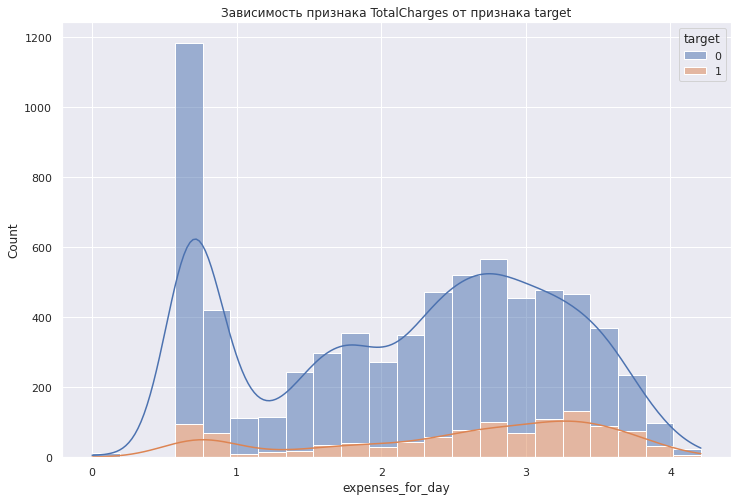

In [102]:
# Проведем  дополнительный анализ признака expenses_for_day
# посмотрим на зависимость целевой переменной от этого признака
sns.histplot(data=data, x='expenses_for_day', hue='target', multiple='stack', stat='count', kde=True)
plt.title(f'Зависимость признака TotalCharges от признака target');

In [103]:
# Посмотрим на средние расходы для каждой из групп клиентов
data.groupby('target', as_index=False).agg({'expenses_for_day' : ['mean', 'median']})

target expenses_for_day       
                     mean median
0      0         2.109453   2.28
1      1         2.551599   2.79

In [104]:
data.expenses_for_day.describe()

count    7043.000000
mean        2.178572
std         1.021228
min         0.000000
25%         1.180000
50%         2.360000
75%         3.030000
max         4.210000
Name: expenses_for_day, dtype: float64

Опираясь на график и статистическое распределение признака `expenses_for_day` можно предположить, что абоненты расторгнувшие договор в среднем потратили больше средств на оплату услуг связи и интернета.

Проверим с помощью t-теста эту гипотезу.

**Нулевая гипотеза:** средний расходы на услуги связи и интернета у действующих и ушедших абонентов равны.

**Альтернативная гипотеза:** в среднем расходы на услуги связи и интернета действующих абонентов оператора связи ниже, чем у клиентов, расторгнувших договор.

In [105]:
# задаём уровень статистической значимости
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
hypothesis_results = st.ttest_ind(data.query('target == 0')['expenses_for_day'], 
                                  data.query('target == 1')['expenses_for_day'], 
                                  alternative='less')

print(f'p-value: {hypothesis_results.pvalue}')

if hypothesis_results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.5802374332800589e-40
Отвергаем нулевую гипотезу


Похоже, что наше предположение подтвердилось. Тут можно рекомендовать биснесу разработать программу лояльности для клиентов с расходами на услуги связи и интернета выше среднего уровня. Например, предлагать скидки, получать кэш-бэк, разработать пакетные предложения.

## Общий вывод

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для своевременного поиска таких клиентов «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Наша задача состояла в том, чтобы обучить модель для прогноза оттока клиентов.

Для выполнения поставленной задачи нам предоставили обезличенные персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

Мы провели предобработку и анализ предоставленных данных: проверили наличие пропусков и аномалий в данных; объединили в один датасет; разработали новые признаки - `ContractLength (продолжительность договора в днях)`, `num_of_services (количество подключенных услуг)`, `expenses_for_day (расходы на услуги связи и интернета в день)` и выявили следующие закономероности:
* *Расторгают контракт абоненты с ежемесячным платежом выше среднего значения.*
* *Уходят клиенты с ежедневным платежом выше среднего значения.*
* *Чаще других уходят клиенты, получающие электронный чек. С ним проще вести учет расходов.*
* *Клиенты, оплачивающие кредитной картой услуги оператора ТелеДом, чаще других склонны к расторжению контракта*
* *Пенсионеры склонны прекращать пользоваться услугами оператора связи. Возможно нет потребоности, а возможно просто дорого.*
* *Клиенты состоящие в браке склонны к расторжению договора. Возможно, причиной этого является оптимизация расходов.*
* *Абоненты с детьми склонны к расторжению договора. Можно предположить причину - оптимизация расходов.*
* *Наличие большого числа подключенных услуг (3 и более), может подтолкнуть клиента к прекращению договорных отношений.*

Потом мы подготовленные данные разделили на тренировочные и тестовые. Обучили на тренировочных данных несколько различных классов моделей, подобрали гиперпараметры. Наш выбор пал на следующие модели:
1. LogisticRegression
2. RandomForestClassifier
3. CatBoostClassifier
4. NeuralNetwork

Выбрали лучшую модель по метрике `roc_auc` - она позволяет оценить качество работы модели вне зависимости от выбранного порога вероятности и дисбаланса классов. Ей оказалась модель *CatBoostClassifier* со значением метрики равным **0.92**

Далее, на тестовой выборке проверили качество лучшей модели. Получили следующие результаты:
* **Метрика roc_auc на тестовых данных - 0.92**
* **Метрика accuracy на тестовых данных - 0.90. Показывает общую способность модели верно предсказывать класс.**

Потом провели анализ полученных полученных результатов:
* Модель хоть и показывает хорошие общие результаты, но не лучшим образом предсказывает класс **"ушедшие клиенты"** - точность составляет **0.74**. Зато **"оставшихся абонентов"** выявляет очень хорошо - **0.93**. Это, вероятней всего, связано с малым количеством данных по **"ушедшим абонентам"**. Тут стоит отметить, что можно настроить точность предсказания одного из классов. Делается это с помощью сдвига порога классификации. Например, сдвинув порог в сторону уменьшения кол-во ложноотрицательных ошибок (сейчас их 72), мы увеличим не только кол-во верных предсказаний класса 1, но и кол-во ложноположительных ошибок (сейчас их 97). Переведем это на язык конкретных дейсвтий: в данном случае, мы будем пытаться с помощью, например, предоставления дополнительный скидки на услуги, удержать еще большее кол-во клиентов, которые в том числе и так не собирались уходить.  Поэтому при принятии таких решений на первый план выходит экономическая целесообразность и бизнес-метрики, такие как стоимость удержания клинета, средняя прибыль с клиента.  
* Наиболее важными признаками для модели являются `длительность контракта с клиентом (в днях), тип оплаты, количество подключенных услуг, расходы на услуги связи и интернета в день и наличие у абонента супруга/супрги`. Отчасти это пересекается с выявленными закономерностями

Модель можно улучшить, обучив её на бОльшем объеме данных. Также возможно настроить под задачи предсказания конкретного класса с помощью порога классификации.

**Рекомендации бизнесу:**
* Разработать программу лояльности для клиентов с большим сроком пользования услугами/связью.
* Сфокусироваться на удержании клиентов с большими ежемесячными тратами. Например, предлагать скидки, получать кэш-бэк, разработать пакетные предложения.
* Собирать больше различных данных по клиентам. Возможно, есть и другие факторы влияющие на отток клиентов 